# Currency Analysis - Sapphire Capital Partners

**Comprehensive analysis of USD exchange rates vs EUR, GBP, and CAD**

This notebook provides:
- 90-day trend analysis
- Volatility assessment with log returns
- Year-over-year comparison
- Correlation analysis for diversification
- Trading signals and strategic recommendations

**Data Source:** US Treasury Fiscal Data API (quarterly reporting)

In [127]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import requests
import time
from datetime import datetime, timedelta
import json
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("All libraries loaded successfully")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries loaded successfully
Analysis started: 2025-11-26 17:50:12


In [128]:
# Configuration
API_URL = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/rates_of_exchange"
START_DATE = "2020-01-01"

CURRENCIES = {
    'EUR': 'Euro Zone-Euro',
    'GBP': 'United Kingdom-Pound',
    'CAD': 'Canada-Dollar'
}

COLORS = {'EUR': '#1f77b4', 'GBP': '#ff7f0e', 'CAD': '#2ca02c'}

# Analysis parameters
TREND_DAYS = 90
HIGH_VOL_THRESHOLD = 10.0
SIGNIFICANT_MOVE_THRESHOLD = 2.0

print("Configuration loaded")
print(f"Currencies: {list(CURRENCIES.keys())}")
print(f"Start date: {START_DATE}")

Configuration loaded
Currencies: ['EUR', 'GBP', 'CAD']
Start date: 2020-01-01


In [129]:
# Fetch and clean data in one step
print("Fetching data from US Treasury API...")
print("-" * 60)

def fetch_currency_data(currency_code, currency_name):
    """Fetch data with proper error handling for pagination."""
    print(f"Fetching {currency_code}...", end=' ')
    
    all_records = []
    page = 1
    
    while page <= 5:
        params = {
            'fields': 'country_currency_desc,exchange_rate,record_date',
            'filter': f'country_currency_desc:in:({currency_name}),record_date:gte:{START_DATE}',
            'page[size]': 100,
            'page[number]': page
        }
        
        try:
            response = requests.get(API_URL, params=params, timeout=30)
            
            if response.status_code == 400:
                break
            
            response.raise_for_status()
            data = response.json()
            records = data.get('data', [])
            
            if not records:
                break
            
            all_records.extend(records)
            
            if not data.get('links', {}).get('next'):
                break
            
            page += 1
            time.sleep(1)
            
        except Exception as e:
            print(f"Error: {e}")
            return None
    
    if all_records:
        df = pd.DataFrame(all_records)
        print(f"Retrieved {len(df)} records")
        return df
    else:
        print("No data")
        return None

# Fetch all currencies
dataframes = []
for code, name in CURRENCIES.items():
    df = fetch_currency_data(code, name)
    if df is not None:
        df['currency_code'] = code
        dataframes.append(df)
    time.sleep(2)

if not dataframes:
    raise Exception("Failed to fetch data")

# Combine and clean
data = pd.concat(dataframes, ignore_index=True)
data['record_date'] = pd.to_datetime(data['record_date'])
data['exchange_rate'] = pd.to_numeric(data['exchange_rate'], errors='coerce')

# Remove future dates
today = datetime.now().date()
data = data[data['record_date'].dt.date <= today].copy()

# Remove duplicates and invalid data
data = data.drop_duplicates(subset=['currency_code', 'record_date'], keep='last')
data = data.dropna(subset=['exchange_rate'])
data = data.sort_values(['currency_code', 'record_date']).reset_index(drop=True)

print("\n" + "=" * 60)
print("Data Summary")
print("=" * 60)
print(f"Total records: {len(data)}")
print(f"Date range: {data['record_date'].min().date()} to {data['record_date'].max().date()}")
print(f"Currencies: {sorted(data['currency_code'].unique())}")
print("\nRecords per currency:")
for curr in sorted(data['currency_code'].unique()):
    print(f"  {curr}: {len(data[data['currency_code']==curr])} records")

Fetching data from US Treasury API...
------------------------------------------------------------
Fetching EUR... Retrieved 23 records
Fetching GBP... Retrieved 24 records
Fetching CAD... Retrieved 23 records

Data Summary
Total records: 69
Date range: 2020-03-31 to 2025-09-30
Currencies: ['CAD', 'EUR', 'GBP']

Records per currency:
  CAD: 23 records
  EUR: 23 records
  GBP: 23 records


In [130]:
# Calculate 90-day trends
print("\n" + "=" * 60)
print("90-Day Trend Analysis")
print("=" * 60)

trends = {}
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].sort_values('record_date')
    
    if len(curr_data) < 2:
        continue
    
    latest = curr_data.iloc[-1]
    target_date = latest['record_date'] - timedelta(days=TREND_DAYS)
    older_data = curr_data[curr_data['record_date'] <= target_date]
    
    if len(older_data) > 0:
        older = older_data.iloc[-1]
    else:
        older = curr_data.iloc[0]
    
    actual_days = (latest['record_date'] - older['record_date']).days
    change_pct = ((latest['exchange_rate'] - older['exchange_rate']) / older['exchange_rate']) * 100
    
    trends[currency] = {
        'latest_rate': latest['exchange_rate'],
        'change_pct': change_pct,
        'actual_days': actual_days,
        'direction': 'strengthened' if change_pct < 0 else 'weakened'
    }
    
    print(f"\n{currency}:")
    print(f"  Current rate: {latest['exchange_rate']:.4f}")
    print(f"  {actual_days}-day change: {change_pct:+.2f}%")
    print(f"  USD has {trends[currency]['direction']} vs {currency}")
    
    if abs(change_pct) > SIGNIFICANT_MOVE_THRESHOLD:
        print(f"  ALERT: Significant movement detected")


90-Day Trend Analysis

CAD:
  Current rate: 1.3920
  92-day change: +1.83%
  USD has weakened vs CAD

EUR:
  Current rate: 0.8520
  92-day change: -0.12%
  USD has strengthened vs EUR

GBP:
  Current rate: 0.7440
  92-day change: +1.92%
  USD has weakened vs GBP


In [131]:
# Calculate volatility using log returns
print("\n" + "=" * 60)
print("Volatility Analysis (Log Returns)")
print("=" * 60)

volatility_metrics = {}
volatility_data = {}

for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].sort_values('record_date').copy()
    
    # Log returns
    curr_data['log_return'] = np.log(curr_data['exchange_rate'] / curr_data['exchange_rate'].shift(1))
    
    # Rolling volatility (4 quarters = 1 year)
    curr_data['rolling_vol'] = curr_data['log_return'].rolling(4).std() * np.sqrt(4) * 100
    
    vol_data = curr_data['rolling_vol'].dropna()
    if len(vol_data) > 0:
        current_vol = vol_data.iloc[-1]
        avg_vol = vol_data.mean()
        
        volatility_metrics[currency] = {
            'current': current_vol,
            'average': avg_vol
        }
        volatility_data[currency] = curr_data
        
        print(f"\n{currency}:")
        print(f"  Current volatility: {current_vol:.2f}%")
        print(f"  Average volatility: {avg_vol:.2f}%")
        
        if current_vol > HIGH_VOL_THRESHOLD:
            print(f"  ALERT: High volatility (>{HIGH_VOL_THRESHOLD}%)")


Volatility Analysis (Log Returns)

CAD:
  Current volatility: 9.15%
  Average volatility: 5.42%

EUR:
  Current volatility: 13.05%
  Average volatility: 8.86%
  ALERT: High volatility (>10.0%)

GBP:
  Current volatility: 10.99%
  Average volatility: 7.40%
  ALERT: High volatility (>10.0%)


In [132]:
# Year-over-year analysis
print("\n" + "=" * 60)
print("Year-over-Year Analysis")
print("=" * 60)

yoy_analysis = {}
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].copy()
    curr_data['year'] = curr_data['record_date'].dt.year
    
    years = sorted(curr_data['year'].unique())
    if len(years) >= 2:
        current_year = years[-1]
        prev_year = years[-2]
        
        current_avg = curr_data[curr_data['year'] == current_year]['exchange_rate'].mean()
        prev_avg = curr_data[curr_data['year'] == prev_year]['exchange_rate'].mean()
        
        yoy_change = ((current_avg - prev_avg) / prev_avg) * 100
        
        yoy_analysis[currency] = {
            'current_year': current_year,
            'prev_year': prev_year,
            'yoy_change': yoy_change
        }
        
        print(f"\n{currency} ({current_year} vs {prev_year}):")
        print(f"  {current_year} average: {current_avg:.4f}")
        print(f"  {prev_year} average: {prev_avg:.4f}")
        print(f"  YoY change: {yoy_change:+.2f}%")


Year-over-Year Analysis

CAD (2025 vs 2024):
  2025 average: 1.3980
  2024 average: 1.3787
  YoY change: +1.40%

EUR (2025 vs 2024):
  2025 average: 0.8763
  2024 average: 0.9290
  YoY change: -5.67%

GBP (2025 vs 2024):
  2025 average: 0.7487
  2024 average: 0.7815
  YoY change: -4.20%


In [133]:
# Correlation analysis
print("\n" + "=" * 60)
print("Correlation Analysis")
print("=" * 60)

pivot_data = data.pivot(index='record_date', columns='currency_code', values='exchange_rate')
correlations = pivot_data.corr()

print("\nCorrelation Matrix:")
print(correlations)

high_corr_pairs = []
currencies_list = sorted(data['currency_code'].unique())
for i in range(len(currencies_list)):
    for j in range(i + 1, len(currencies_list)):
        corr_val = correlations.loc[currencies_list[i], currencies_list[j]]
        print(f"\n{currencies_list[i]}-{currencies_list[j]}: {corr_val:.3f}", end="")
        if abs(corr_val) > 0.7:
            print(" (HIGH - limited diversification)")
            high_corr_pairs.append((currencies_list[i], currencies_list[j], corr_val))
        else:
            print(" (MODERATE)")


Correlation Analysis

Correlation Matrix:
currency_code       CAD       EUR       GBP
currency_code                              
CAD            1.000000  0.452577  0.470141
EUR            0.452577  1.000000  0.786950
GBP            0.470141  0.786950  1.000000

CAD-EUR: 0.453 (MODERATE)

CAD-GBP: 0.470 (MODERATE)

EUR-GBP: 0.787 (HIGH - limited diversification)


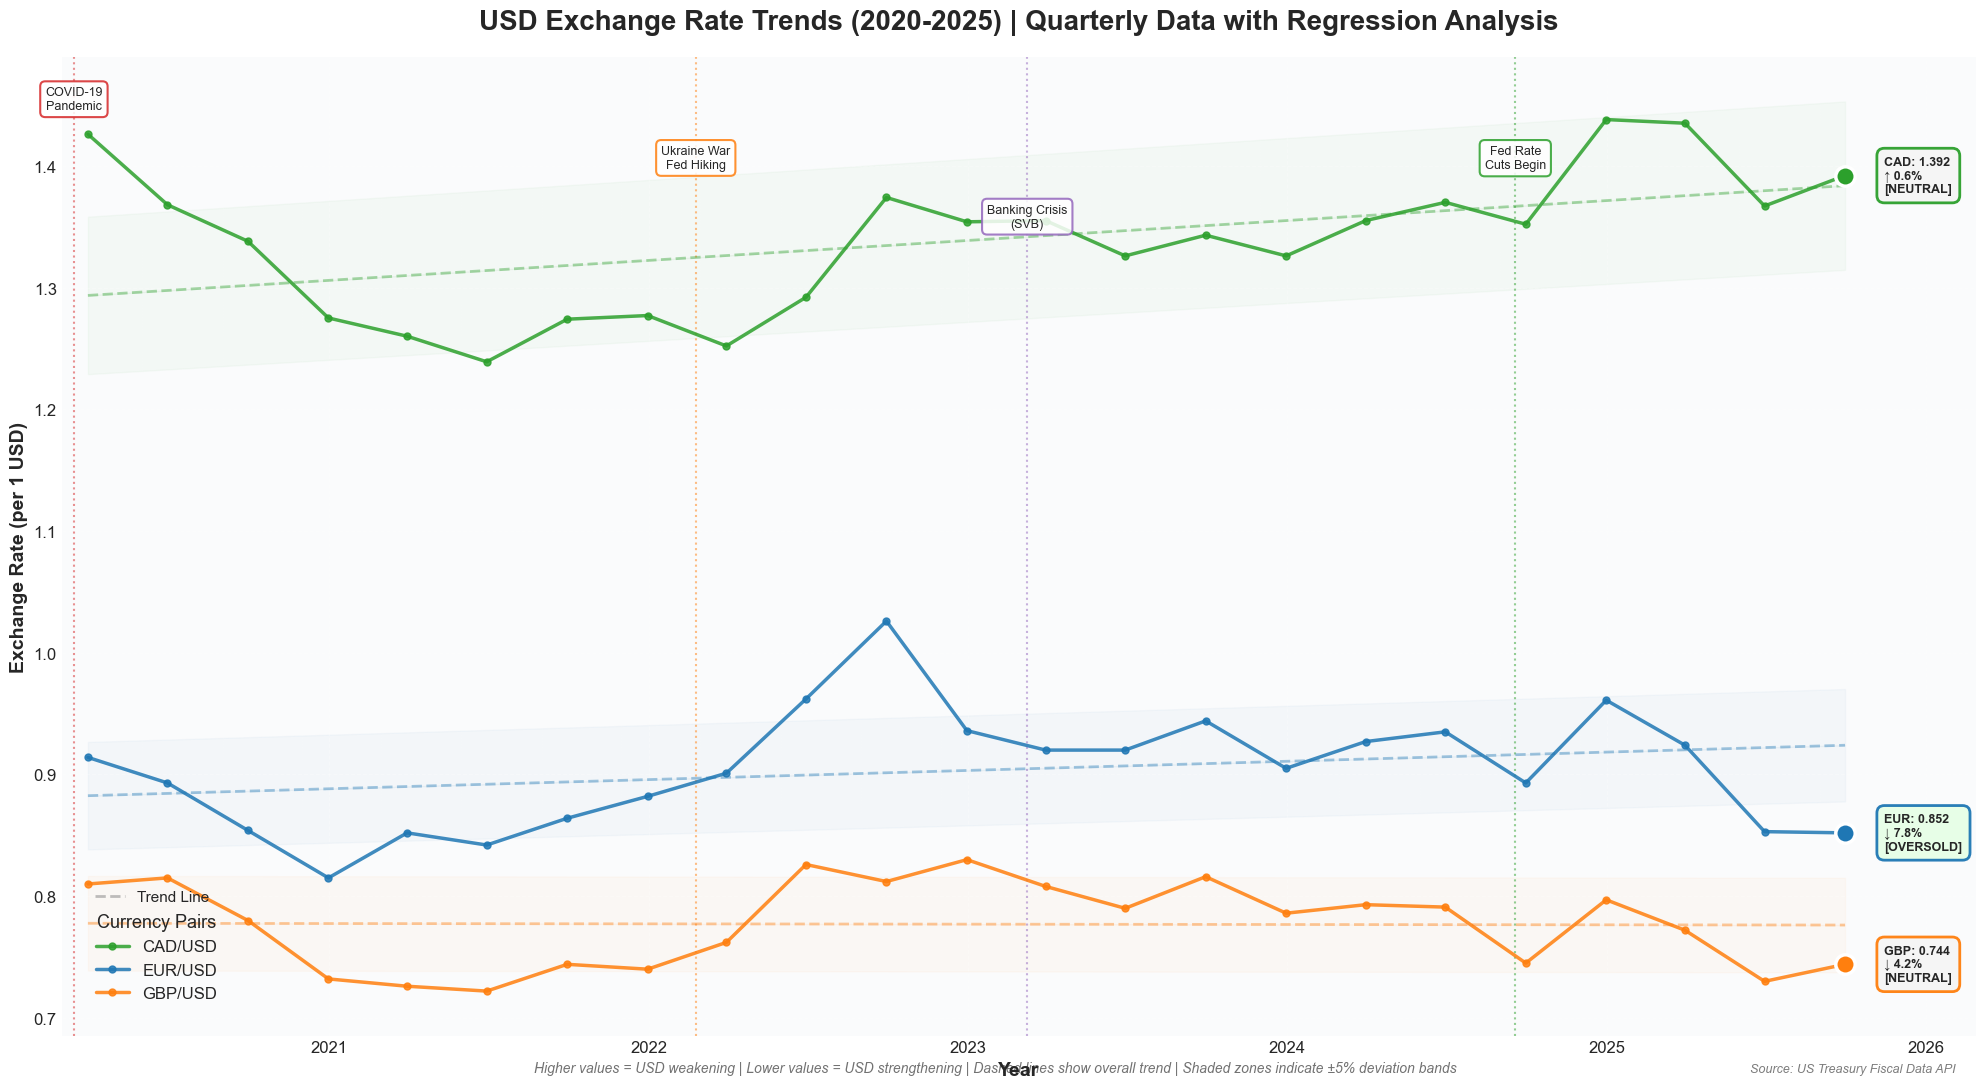

Saved: timeline_enhanced.png

ENHANCED TREND LINE ANALYSIS WITH TRADING SIGNALS

CAD - Current Analysis:
  Overall Trend: WEAKENING (USD depreciating)
  R-squared: 0.2339 (trend strength)
  Current Rate: 1.3920
  Trend Value: 1.3837
  Deviation: +0.60%
  Trading Signal: 📊 NEUTRAL - Hold current positions
  Annualized trend rate: +1.15% per year

EUR - Current Analysis:
  Overall Trend: WEAKENING (USD depreciating)
  R-squared: 0.0701 (trend strength)
  Current Rate: 0.8520
  Trend Value: 0.9240
  Deviation: -7.79%
  Trading Signal: ✅ OVERSOLD - Potential BUY opportunity
  Annualized trend rate: +0.82% per year

GBP - Current Analysis:
  Overall Trend: STRENGTHENING (USD appreciating)
  R-squared: 0.0002 (trend strength)
  Current Rate: 0.7440
  Trend Value: 0.7763
  Deviation: -4.16%
  Trading Signal: ⚡ WATCH - Approaching signal zone
  Annualized trend rate: -0.03% per year



In [134]:
# Visualization 1: Clean Enhanced Timeline - No Overlaps
import numpy as np
from scipy import stats
from datetime import datetime

fig, ax = plt.subplots(figsize=(20, 11))

# Dictionary to store current positions
current_positions = {}

# Plot each currency with its data points and trend line
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].sort_values('record_date')
    
    # Convert dates to numeric values for trend line calculation
    dates_numeric = mdates.date2num(curr_data['record_date'])
    rates = curr_data['exchange_rate'].values
    
    # Calculate linear trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(dates_numeric, rates)
    trend_line = slope * dates_numeric + intercept
    
    # Store current position data
    current_rate = rates[-1]
    current_trend = trend_line[-1]
    deviation_pct = ((current_rate - current_trend) / current_trend) * 100
    current_positions[currency] = {
        'rate': current_rate,
        'trend': current_trend,
        'deviation': deviation_pct,
        'date': curr_data['record_date'].iloc[-1]
    }
    
    # Trading Signal Zones (very subtle)
    upper_band = trend_line * 1.05
    lower_band = trend_line * 0.95
    
    ax.fill_between(curr_data['record_date'], trend_line, upper_band,
                     color=COLORS[currency], alpha=0.03, zorder=0)
    ax.fill_between(curr_data['record_date'], lower_band, trend_line,
                     color=COLORS[currency], alpha=0.03, zorder=0)
    
    # Plot actual data points
    ax.plot(curr_data['record_date'], rates,
            label=f'{currency}/USD', 
            color=COLORS[currency], 
            linewidth=2.5, marker='o', markersize=5, alpha=0.85,
            zorder=3)
    
    # Plot trend line (dashed)
    ax.plot(curr_data['record_date'], trend_line,
            color=COLORS[currency], linewidth=2, linestyle='--', 
            alpha=0.4, zorder=2)
    
    # Bold dot on latest value
    ax.plot(curr_data['record_date'].iloc[-1], rates[-1],
            marker='o', markersize=14, color=COLORS[currency],
            markeredgecolor='white', markeredgewidth=2.5, zorder=5)

# Event Annotations - STAGGERED VERTICALLY to avoid overlap
events = [
    {'date': datetime(2020, 3, 15), 'label': 'COVID-19\nPandemic', 
     'y_position': 0.97, 'color': '#d62728'},
    {'date': datetime(2022, 2, 24), 'label': 'Ukraine War\nFed Hiking', 
     'y_position': 0.91, 'color': '#ff7f0e'},
    {'date': datetime(2023, 3, 10), 'label': 'Banking Crisis\n(SVB)', 
     'y_position': 0.85, 'color': '#9467bd'},
    {'date': datetime(2024, 9, 18), 'label': 'Fed Rate\nCuts Begin', 
     'y_position': 0.91, 'color': '#2ca02c'}
]

y_min, y_max = ax.get_ylim()
for event in events:
    # Event marker line
    ax.axvline(x=event['date'], color=event['color'], linestyle=':', 
               linewidth=1.5, alpha=0.5, zorder=1)
    
    # Event label - positioned at different heights
    y_coord = y_min + (y_max - y_min) * event['y_position']
    ax.text(event['date'], y_coord, event['label'],
            rotation=0, ha='center', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor=event['color'], linewidth=1.5, alpha=0.85),
            zorder=4)

# Current Position Callouts - POSITIONED TO THE RIGHT, NO OVERLAP
# Calculate position for callout panel
last_date = data['record_date'].max()
callout_x = last_date + pd.Timedelta(days=45)  # Position to the right

# Create a clean callout area
for idx, (currency, pos_data) in enumerate(sorted(current_positions.items())):
    direction = "↑" if pos_data['deviation'] > 0 else "↓"
    
    # Determine signal
    if abs(pos_data['deviation']) > 5:
        signal = "OVERBOUGHT" if pos_data['deviation'] > 0 else "OVERSOLD"
        box_color = '#ffe6e6' if pos_data['deviation'] > 0 else '#e6ffe6'
    else:
        signal = "NEUTRAL"
        box_color = '#f5f5f5'
    
    # Position callouts vertically based on currency
    # Get the actual y-position of the last data point
    callout_y = pos_data['rate']
    
    # Create clean, compact callout
    callout_text = f"{currency}: {pos_data['rate']:.3f}\n{direction} {abs(pos_data['deviation']):.1f}%\n[{signal}]"
    
    ax.text(callout_x, callout_y,
            callout_text,
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor=box_color, 
                     edgecolor=COLORS[currency], linewidth=2, alpha=0.95),
            verticalalignment='center',
            zorder=6)

# Configure axes
ax.set_xlabel('Year', fontweight='bold', fontsize=14)
ax.set_ylabel('Exchange Rate (per 1 USD)', fontweight='bold', fontsize=14)
ax.set_title('USD Exchange Rate Trends (2020-2025) | Quarterly Data with Regression Analysis', 
             fontsize=20, fontweight='bold', pad=20)

# Set x-axis to show YEARLY labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))

plt.xticks(rotation=0, fontsize=12)  # Horizontal year labels
ax.tick_params(axis='y', labelsize=12)

# Add grid - subtle
ax.grid(True, alpha=0.25, linestyle='--', which='major', zorder=0)
ax.grid(True, alpha=0.12, linestyle=':', which='minor', zorder=0)

# Legend - BOTTOM LEFT to avoid data overlap
legend = ax.legend(loc='lower left', fontsize=12, framealpha=0.95,
                   title='Currency Pairs', title_fontsize=13,
                   bbox_to_anchor=(0.01, 0.02))

# Add legend entry for trend lines
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=2, linestyle='--', 
           alpha=0.5, label='Trend Line')
]
legend2 = ax.legend(handles=legend_elements, loc='lower left', 
                   fontsize=11, framealpha=0.95,
                   bbox_to_anchor=(0.01, 0.12))
ax.add_artist(legend)  # Add first legend back

# Enhanced footer
plt.figtext(0.5, 0.02, 
           'Higher values = USD weakening | Lower values = USD strengthening | Dashed lines show overall trend | Shaded zones indicate ±5% deviation bands',
           ha='center', fontsize=10, style='italic', alpha=0.65)

# Data source - bottom right
plt.figtext(0.98, 0.02, 
           'Source: US Treasury Fiscal Data API',
           ha='right', fontsize=9, style='italic', alpha=0.6)

# Professional styling
ax.set_facecolor('#fafbfc')
fig.patch.set_facecolor('white')

# Extend x-axis slightly to make room for callouts
ax.set_xlim(data['record_date'].min() - pd.Timedelta(days=30),
            last_date + pd.Timedelta(days=150))

plt.tight_layout()
plt.savefig('timeline_enhanced.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: timeline_enhanced.png")

# Print trend analysis
print("\n" + "=" * 80)
print("ENHANCED TREND LINE ANALYSIS WITH TRADING SIGNALS")
print("=" * 80)
for currency in sorted(data['currency_code'].unique()):
    curr_data = data[data['currency_code'] == currency].sort_values('record_date')
    dates_numeric = mdates.date2num(curr_data['record_date'])
    rates = curr_data['exchange_rate'].values
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(dates_numeric, rates)
    
    trend_direction = "WEAKENING (USD depreciating)" if slope > 0 else "STRENGTHENING (USD appreciating)"
    pos_data = current_positions[currency]
    
    print(f"\n{currency} - Current Analysis:")
    print(f"  Overall Trend: {trend_direction}")
    print(f"  R-squared: {r_value**2:.4f} (trend strength)")
    print(f"  Current Rate: {pos_data['rate']:.4f}")
    print(f"  Trend Value: {pos_data['trend']:.4f}")
    print(f"  Deviation: {pos_data['deviation']:+.2f}%")
    
    # Trading signal
    if abs(pos_data['deviation']) > 5:
        if pos_data['deviation'] > 5:
            signal = "⚠️ OVERBOUGHT - Consider SHORT positions"
        else:
            signal = "✅ OVERSOLD - Potential BUY opportunity"
    elif abs(pos_data['deviation']) > 2:
        signal = "⚡ WATCH - Approaching signal zone"
    else:
        signal = "📊 NEUTRAL - Hold current positions"
    
    print(f"  Trading Signal: {signal}")
    
    # Annualized rate
    days_span = (curr_data['record_date'].max() - curr_data['record_date'].min()).days
    years_span = days_span / 365.25
    total_trend_change = slope * dates_numeric.max() - slope * dates_numeric.min()
    annualized_pct = (total_trend_change / rates[0]) * 100 / years_span
    print(f"  Annualized trend rate: {annualized_pct:+.2f}% per year")

print("\n" + "=" * 80)

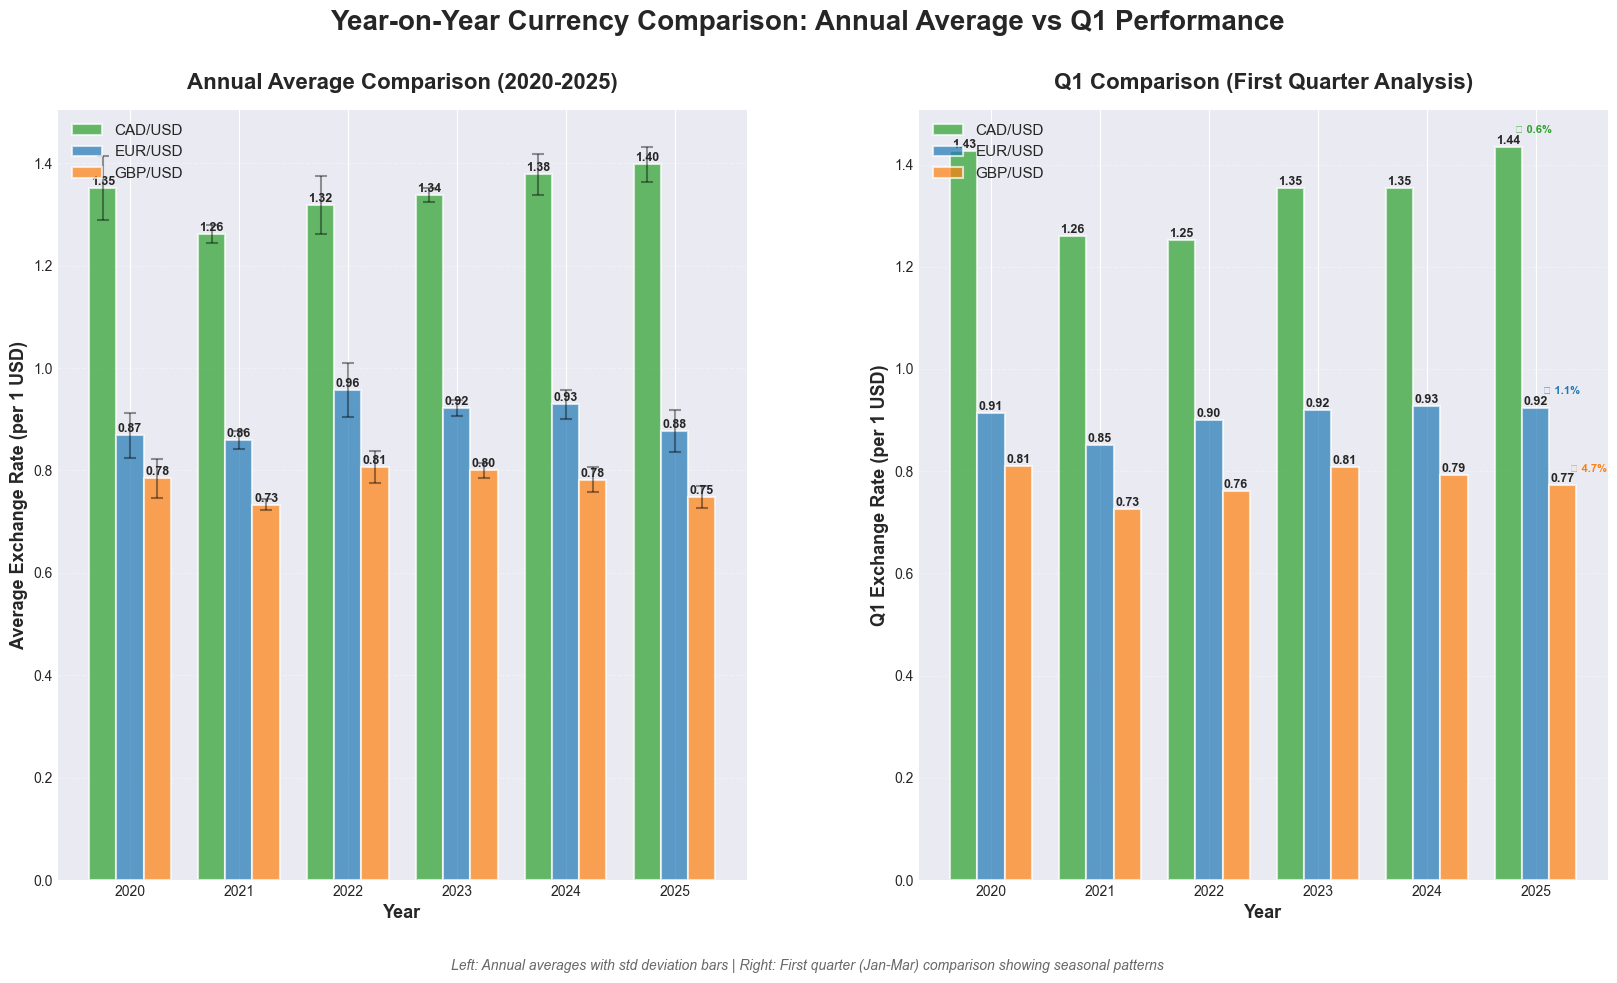

Saved: year_comparison.png

YEAR-ON-YEAR ANALYSIS SUMMARY

ANNUAL AVERAGES:
--------------------------------------------------------------------------------

CAD:
  2020 Average: 1.3518
  2025 Average: 1.3980
  Total Change: +3.42%

EUR:
  2020 Average: 0.8690
  2025 Average: 0.8763
  Total Change: +0.84%

GBP:
  2020 Average: 0.7843
  2025 Average: 0.7487
  Total Change: -4.54%

Q1 PERFORMANCE:
--------------------------------------------------------------------------------

CAD:
  Q1 2020: 1.4260
  Q1 2025: 1.4350
  Q1 Change: +0.63%

EUR:
  Q1 2020: 0.9140
  Q1 2025: 0.9240
  Q1 Change: +1.09%

GBP:
  Q1 2020: 0.8100
  Q1 2025: 0.7720
  Q1 Change: -4.69%



In [135]:
# Visualization 2: Enhanced Year-on-Year with Q1 Comparison
import numpy as np
from matplotlib.gridspec import GridSpec

# Prepare data
data_with_year = data.copy()
data_with_year['year'] = data_with_year['record_date'].dt.year
data_with_year['quarter'] = data_with_year['record_date'].dt.quarter

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig, wspace=0.25)

# ============================================================================
# LEFT SIDE: Annual Average Comparison (All Currencies Together)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

years = sorted(data_with_year['year'].unique())
currencies = sorted(data['currency_code'].unique())
x = np.arange(len(years))
width = 0.25  # Width of bars

for idx, currency in enumerate(currencies):
    curr_data = data_with_year[data_with_year['currency_code'] == currency]
    yearly_avg = curr_data.groupby('year')['exchange_rate'].mean()
    yearly_std = curr_data.groupby('year')['exchange_rate'].std()
    
    # Position bars side by side
    positions = x + (idx - 1) * width
    
    bars = ax1.bar(positions, yearly_avg, width, 
                   label=f'{currency}/USD',
                   color=COLORS[currency], alpha=0.7,
                   edgecolor='white', linewidth=1.5)
    
    # Add error bars showing volatility (std deviation)
    ax1.errorbar(positions, yearly_avg, yerr=yearly_std,
                 fmt='none', ecolor='black', capsize=4, capthick=1.5, alpha=0.4)
    
    # Add value labels on bars
    for pos, val in zip(positions, yearly_avg):
        ax1.text(pos, val, f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_xlabel('Year', fontweight='bold', fontsize=13)
ax1.set_ylabel('Average Exchange Rate (per 1 USD)', fontweight='bold', fontsize=13)
ax1.set_title('Annual Average Comparison (2020-2025)', fontsize=16, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# ============================================================================
# RIGHT SIDE: Q1 Comparison (First Quarter Only)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])

# Filter for Q1 data only
q1_data = data_with_year[data_with_year['quarter'] == 1].copy()

years_q1 = sorted(q1_data['year'].unique())
x_q1 = np.arange(len(years_q1))

for idx, currency in enumerate(currencies):
    curr_q1 = q1_data[q1_data['currency_code'] == currency]
    q1_avg = curr_q1.groupby('year')['exchange_rate'].mean()
    
    # Position bars side by side
    positions = x_q1 + (idx - 1) * width
    
    bars = ax2.bar(positions, q1_avg, width,
                   label=f'{currency}/USD',
                   color=COLORS[currency], alpha=0.7,
                   edgecolor='white', linewidth=1.5)
    
    # Add value labels
    for pos, val in zip(positions, q1_avg):
        ax2.text(pos, val, f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add trend arrow for Q1 performance
    if len(q1_avg) >= 2:
        q1_change = ((q1_avg.iloc[-1] - q1_avg.iloc[0]) / q1_avg.iloc[0]) * 100
        arrow = "↗" if q1_change > 0 else "↘"
        color_arrow = COLORS[currency]
        
        # Position arrow annotation
        ax2.annotate(f'{arrow} {abs(q1_change):.1f}%', 
                    xy=(positions[-1], q1_avg.iloc[-1]),
                    xytext=(5, 10), textcoords='offset points',
                    fontsize=8, fontweight='bold', color=color_arrow)

ax2.set_xlabel('Year', fontweight='bold', fontsize=13)
ax2.set_ylabel('Q1 Exchange Rate (per 1 USD)', fontweight='bold', fontsize=13)
ax2.set_title('Q1 Comparison (First Quarter Analysis)', fontsize=16, fontweight='bold', pad=15)
ax2.set_xticks(x_q1)
ax2.set_xticklabels(years_q1)
ax2.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Overall title
fig.suptitle('Year-on-Year Currency Comparison: Annual Average vs Q1 Performance', 
             fontsize=20, fontweight='bold', y=0.98)

# Add footer explanation
plt.figtext(0.5, 0.02, 
           'Left: Annual averages with std deviation bars | Right: First quarter (Jan-Mar) comparison showing seasonal patterns',
           ha='center', fontsize=10, style='italic', alpha=0.7)

plt.savefig('year_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: year_comparison.png")

# Print summary statistics
print("\n" + "=" * 80)
print("YEAR-ON-YEAR ANALYSIS SUMMARY")
print("=" * 80)

print("\nANNUAL AVERAGES:")
print("-" * 80)
for currency in currencies:
    curr_data = data_with_year[data_with_year['currency_code'] == currency]
    yearly = curr_data.groupby('year')['exchange_rate'].mean()
    
    first_year = yearly.iloc[0]
    last_year = yearly.iloc[-1]
    total_change = ((last_year - first_year) / first_year) * 100
    
    print(f"\n{currency}:")
    print(f"  2020 Average: {yearly.iloc[0]:.4f}")
    print(f"  2025 Average: {yearly.iloc[-1]:.4f}")
    print(f"  Total Change: {total_change:+.2f}%")

print("\n" + "=" * 80)
print("Q1 PERFORMANCE:")
print("-" * 80)
for currency in currencies:
    curr_q1 = q1_data[q1_data['currency_code'] == currency]
    q1_yearly = curr_q1.groupby('year')['exchange_rate'].mean()
    
    if len(q1_yearly) >= 2:
        first_q1 = q1_yearly.iloc[0]
        last_q1 = q1_yearly.iloc[-1]
        q1_change = ((last_q1 - first_q1) / first_q1) * 100
        
        print(f"\n{currency}:")
        print(f"  Q1 2020: {first_q1:.4f}")
        print(f"  Q1 2025: {last_q1:.4f}")
        print(f"  Q1 Change: {q1_change:+.2f}%")

print("\n" + "=" * 80)

## 3. Exploratory Analysis

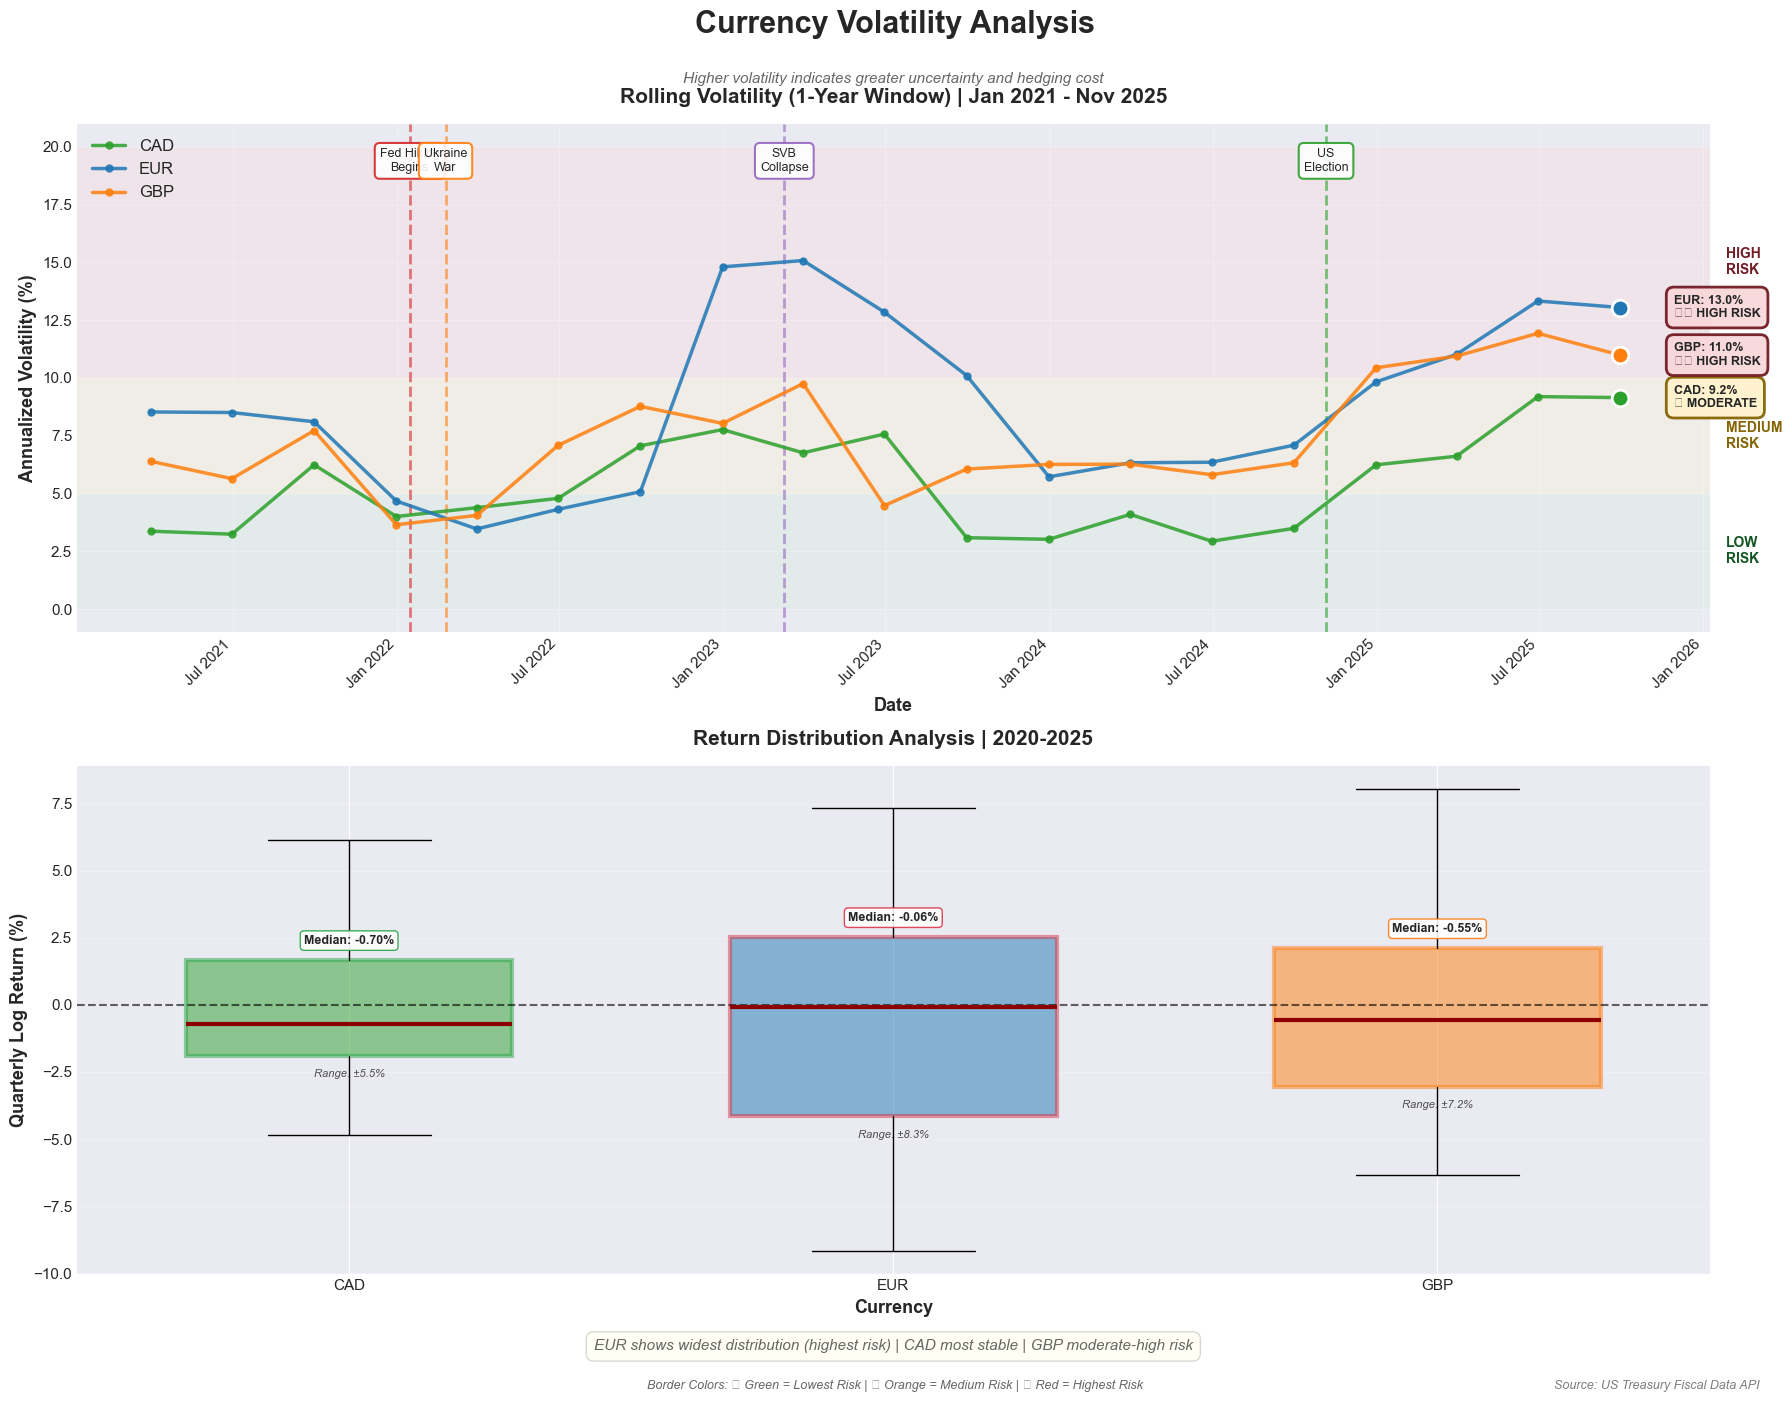

Saved: volatility.png

ENHANCED VOLATILITY ANALYSIS

CURRENT VOLATILITY LEVELS:
--------------------------------------------------------------------------------
CAD: 9.15% - MODERATE RISK ⚡
EUR: 13.05% - HIGH RISK ⚠️
GBP: 10.99% - HIGH RISK ⚠️

RETURN DISTRIBUTION STATISTICS:
--------------------------------------------------------------------------------

CAD (Lowest Risk):
  Median Return: -0.70%
  Std Deviation: 3.02%
  Range: 11.02%
  IQR: 3.58%

EUR (Highest Risk):
  Median Return: -0.06%
  Std Deviation: 4.57%
  Range: 16.52%
  IQR: 6.68%

GBP (Medium Risk):
  Median Return: -0.55%
  Std Deviation: 3.86%
  Range: 14.42%
  IQR: 5.18%

RISK INTERPRETATION:
--------------------------------------------------------------------------------
Most Stable:  CAD (σ = 3.02%)
Most Volatile: EUR (σ = 4.57%)

Higher standard deviation indicates greater price uncertainty and
higher cost of hedging instruments (options, forwards).


In [136]:
# Visualization 3: Enhanced Volatility Analysis with Risk Zones and Events
import numpy as np
from datetime import datetime

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.35)

# ============================================================================
# TOP CHART: Rolling Volatility with Risk Zones and Events
# ============================================================================

# ENHANCEMENT 1: Risk Zone Shading (horizontal bands)
# Low Risk (0-5%): Light green
ax1.axhspan(0, 5, facecolor='#d4edda', alpha=0.3, zorder=0)
# Medium Risk (5-10%): Light yellow
ax1.axhspan(5, 10, facecolor='#fff3cd', alpha=0.3, zorder=0)
# High Risk (10%+): Light red
ax1.axhspan(10, 20, facecolor='#f8d7da', alpha=0.3, zorder=0)

# Risk zone labels on right side
ax1.text(1.01, 2.5, 'LOW\nRISK', transform=ax1.get_yaxis_transform(),
         fontsize=10, fontweight='bold', color='#155724',
         va='center', ha='left')
ax1.text(1.01, 7.5, 'MEDIUM\nRISK', transform=ax1.get_yaxis_transform(),
         fontsize=10, fontweight='bold', color='#856404',
         va='center', ha='left')
ax1.text(1.01, 15, 'HIGH\nRISK', transform=ax1.get_yaxis_transform(),
         fontsize=10, fontweight='bold', color='#721c24',
         va='center', ha='left')

# Store current volatility values for callouts
current_vols = {}

# Plot volatility lines
for currency in sorted(volatility_data.keys()):
    vdata = volatility_data[currency].dropna(subset=['rolling_vol'])
    if len(vdata) > 0:
        ax1.plot(vdata['record_date'], vdata['rolling_vol'],
                label=currency, color=COLORS[currency], linewidth=2.5,
                marker='o', markersize=5, alpha=0.85, zorder=3)
        
        # Store current value
        current_vols[currency] = {
            'value': vdata['rolling_vol'].iloc[-1],
            'date': vdata['record_date'].iloc[-1]
        }
        
        # Bold dot on current value
        ax1.plot(vdata['record_date'].iloc[-1], vdata['rolling_vol'].iloc[-1],
                marker='o', markersize=12, color=COLORS[currency],
                markeredgecolor='white', markeredgewidth=2, zorder=5)

# ENHANCEMENT 2: Event Markers (vertical dashed lines)
events = [
    {'date': datetime(2022, 1, 15), 'label': 'Fed Hiking\nBegins', 'color': '#d62728'},
    {'date': datetime(2022, 2, 24), 'label': 'Ukraine\nWar', 'color': '#ff7f0e'},
    {'date': datetime(2023, 3, 10), 'label': 'SVB\nCollapse', 'color': '#9467bd'},
    {'date': datetime(2024, 11, 5), 'label': 'US\nElection', 'color': '#2ca02c'}
]

for event in events:
    ax1.axvline(x=event['date'], color=event['color'], linestyle='--', 
               linewidth=2, alpha=0.6, zorder=2)
    # Position labels at top of chart
    ax1.text(event['date'], ax1.get_ylim()[1] * 0.95, event['label'],
            rotation=0, ha='center', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor=event['color'], linewidth=1.5, alpha=0.9),
            zorder=4)

# ENHANCEMENT 3: Current Value Callouts (right side)
last_date = max([v['date'] for v in current_vols.values()])
callout_x = last_date + pd.Timedelta(days=60)

for idx, (currency, vol_data) in enumerate(sorted(current_vols.items())):
    vol_value = vol_data['value']
    
    # Determine risk level and icon
    if vol_value > 10:
        risk_label = "⚠️ HIGH RISK"
        box_color = '#f8d7da'
        border_color = '#721c24'
    elif vol_value > 5:
        risk_label = "⚡ MODERATE"
        box_color = '#fff3cd'
        border_color = '#856404'
    else:
        risk_label = "✅ LOW RISK"
        box_color = '#d4edda'
        border_color = '#155724'
    
    callout_text = f"{currency}: {vol_value:.1f}%\n{risk_label}"
    
    ax1.text(callout_x, vol_value,
            callout_text,
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor=box_color, 
                     edgecolor=border_color, linewidth=2, alpha=0.95),
            verticalalignment='center',
            zorder=6)

# Configure axes
ax1.set_xlabel('Date', fontweight='bold', fontsize=13)
ax1.set_ylabel('Annualized Volatility (%)', fontweight='bold', fontsize=13)

# ENHANCEMENT 4: Enhanced Title with Subtitle
ax1.set_title('Rolling Volatility (1-Year Window) | Jan 2021 - Nov 2025', 
             fontweight='bold', fontsize=15, pad=15)
ax1.text(0.5, 1.08, 'Higher volatility indicates greater uncertainty and hedging cost',
        transform=ax1.transAxes, fontsize=11, style='italic',
        ha='center', alpha=0.7)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=11)
ax1.tick_params(axis='y', labelsize=11)
ax1.grid(alpha=0.25, zorder=1)
ax1.legend(loc='upper left', fontsize=12, framealpha=0.95)

# Extend x-axis for callouts
ax1.set_xlim(ax1.get_xlim()[0], callout_x + pd.Timedelta(days=40))

# ============================================================================
# BOTTOM CHART: Return Distribution with Statistical Labels
# ============================================================================

returns_list = []
labels = []
stats = {}

for currency in sorted(volatility_data.keys()):
    returns = volatility_data[currency]['log_return'].dropna() * 100
    mean_ret = returns.mean()
    std_ret = returns.std()
    returns_filtered = returns[abs(returns - mean_ret) < 3 * std_ret]
    
    if len(returns_filtered) > 0:
        returns_list.append(returns_filtered)
        labels.append(currency)
        
        # Calculate statistics
        median_val = returns_filtered.median()
        q1, q3 = returns_filtered.quantile([0.25, 0.75])
        range_val = returns_filtered.max() - returns_filtered.min()
        
        stats[currency] = {
            'median': median_val,
            'q1': q1,
            'q3': q3,
            'range': range_val,
            'std': returns_filtered.std()
        }

# ENHANCEMENT 3: Color-Code by Risk Level
# Determine risk ranking by standard deviation
risk_ranking = sorted(stats.items(), key=lambda x: x[1]['std'])
risk_colors = {
    risk_ranking[0][0]: '#28a745',  # Lowest risk - Green
    risk_ranking[1][0]: '#fd7e14',  # Medium risk - Orange
    risk_ranking[2][0]: '#dc3545'   # Highest risk - Red
}

bp = ax2.boxplot(returns_list, labels=labels, patch_artist=True, widths=0.6)

for patch, currency in zip(bp['boxes'], labels):
    patch.set_facecolor(COLORS[currency])
    patch.set_alpha(0.5)
    # ENHANCEMENT: Color-coded borders by risk
    patch.set_edgecolor(risk_colors[currency])
    patch.set_linewidth(3)

for median in bp['medians']:
    median.set_linewidth(3)
    median.set_color('darkred')

# ENHANCEMENT 1: Statistical Labels on/above each box
for idx, currency in enumerate(labels):
    stat = stats[currency]
    
    # Median label above box
    ax2.text(idx + 1, stat['q3'] + 0.5, 
            f"Median: {stat['median']:.2f}%",
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor=risk_colors[currency], alpha=0.9))
    
    # Range label below box
    ax2.text(idx + 1, stat['q1'] - 0.5,
            f"Range: ±{stat['range']/2:.1f}%",
            ha='center', va='top', fontsize=8, style='italic',
            alpha=0.8)

ax2.set_xlabel('Currency', fontweight='bold', fontsize=13)
ax2.set_ylabel('Quarterly Log Return (%)', fontweight='bold', fontsize=13)
ax2.set_title('Return Distribution Analysis | 2020-2025', 
             fontweight='bold', fontsize=15, pad=15)
ax2.grid(axis='y', alpha=0.25)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.6)
ax2.tick_params(axis='both', labelsize=11)

# ENHANCEMENT 2: Interpretation Text below chart
interpretation = "EUR shows widest distribution (highest risk) | CAD most stable | GBP moderate-high risk"
ax2.text(0.5, -0.15, interpretation,
        transform=ax2.transAxes, fontsize=11, style='italic',
        ha='center', alpha=0.7,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                 edgecolor='gray', alpha=0.3))

# Overall title
fig.suptitle('Currency Volatility Analysis', fontsize=22, fontweight='bold', y=0.995)

# GENERAL ENHANCEMENT: Data Source
plt.figtext(0.98, 0.01, 
           'Source: US Treasury Fiscal Data API',
           ha='right', fontsize=9, style='italic', alpha=0.6)

# Add risk legend for bottom chart
legend_text = "Border Colors: 🟢 Green = Lowest Risk | 🟠 Orange = Medium Risk | 🔴 Red = Highest Risk"
plt.figtext(0.5, 0.01, legend_text,
           ha='center', fontsize=9, style='italic', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('volatility.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: volatility.png")

# Enhanced statistics printout
print("\n" + "=" * 80)
print("ENHANCED VOLATILITY ANALYSIS")
print("=" * 80)

print("\nCURRENT VOLATILITY LEVELS:")
print("-" * 80)
for currency in sorted(current_vols.keys()):
    vol = current_vols[currency]['value']
    if vol > 10:
        risk = "HIGH RISK ⚠️"
    elif vol > 5:
        risk = "MODERATE RISK ⚡"
    else:
        risk = "LOW RISK ✅"
    
    print(f"{currency}: {vol:.2f}% - {risk}")

print("\nRETURN DISTRIBUTION STATISTICS:")
print("-" * 80)
for currency in sorted(stats.keys()):
    stat = stats[currency]
    risk_level = "Lowest" if currency == risk_ranking[0][0] else \
                 "Highest" if currency == risk_ranking[2][0] else "Medium"
    
    print(f"\n{currency} ({risk_level} Risk):")
    print(f"  Median Return: {stat['median']:+.2f}%")
    print(f"  Std Deviation: {stat['std']:.2f}%")
    print(f"  Range: {stat['range']:.2f}%")
    print(f"  IQR: {stat['q3'] - stat['q1']:.2f}%")

print("\n" + "=" * 80)
print("RISK INTERPRETATION:")
print("-" * 80)
print(f"Most Stable:  {risk_ranking[0][0]} (σ = {risk_ranking[0][1]['std']:.2f}%)")
print(f"Most Volatile: {risk_ranking[2][0]} (σ = {risk_ranking[2][1]['std']:.2f}%)")
print("\nHigher standard deviation indicates greater price uncertainty and")
print("higher cost of hedging instruments (options, forwards).")
print("=" * 80)

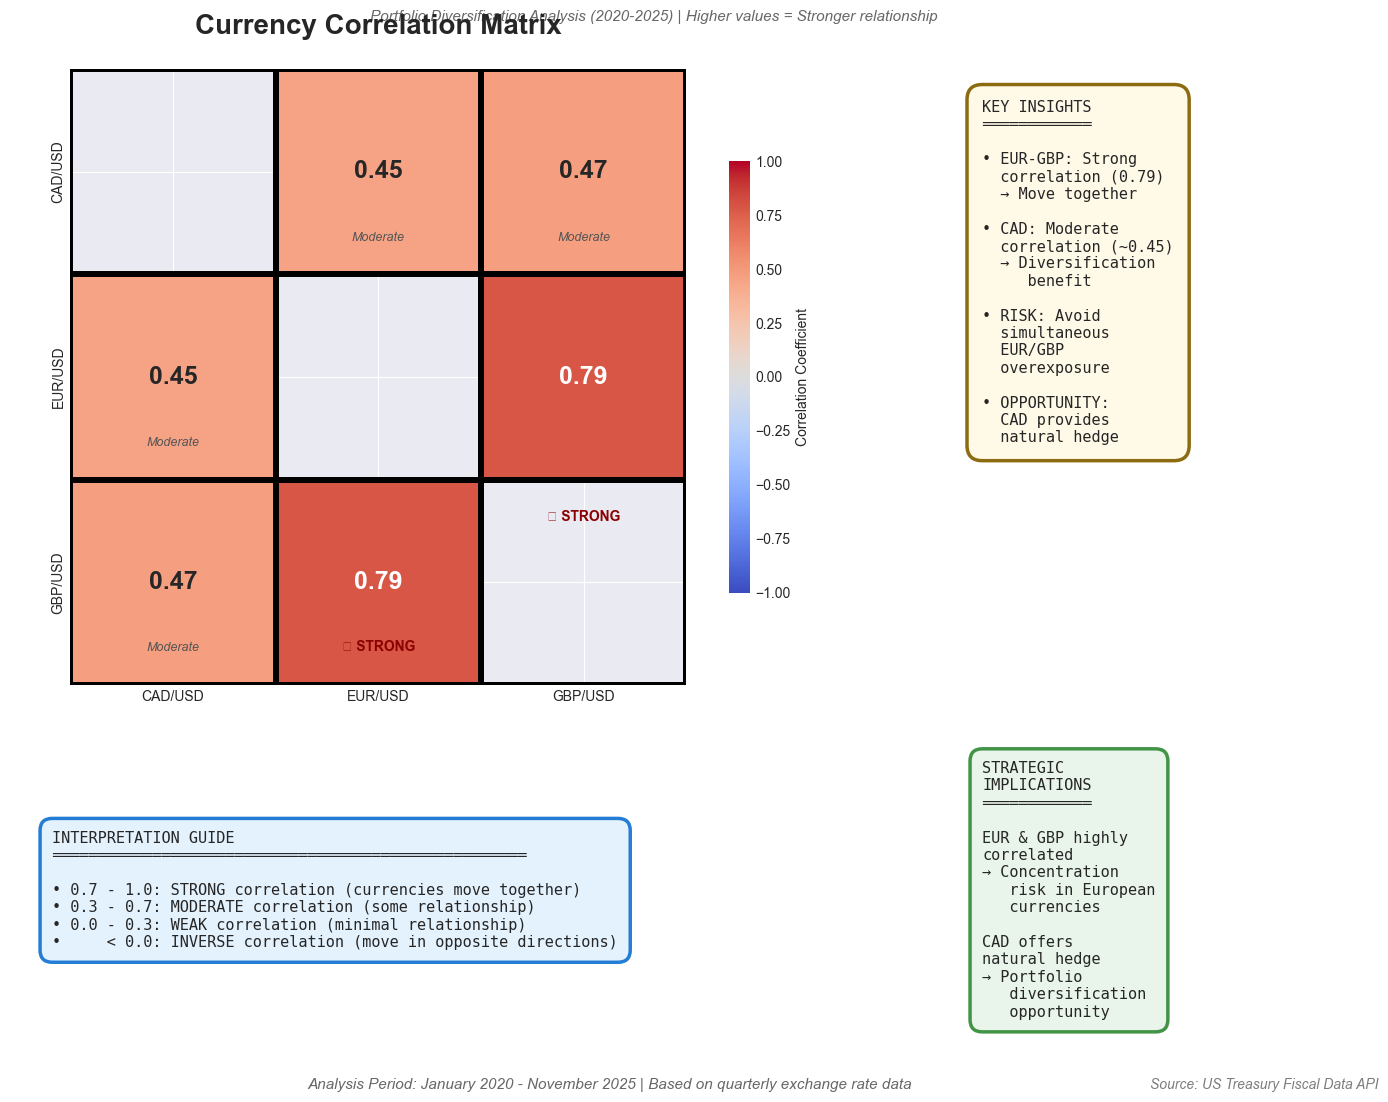

Saved: correlation_heatmap.png

CORRELATION ANALYSIS - STRATEGIC INSIGHTS

CORRELATION MATRIX:
--------------------------------------------------------------------------------
currency_code    CAD    EUR    GBP
currency_code                     
CAD            1.000  0.453  0.470
EUR            0.453  1.000  0.787
GBP            0.470  0.787  1.000

KEY RELATIONSHIPS:
--------------------------------------------------------------------------------

EUR-GBP: 0.787 (STRONG ★)
  Implication: High concentration risk - currencies move together

CAD-GBP: 0.470 (MODERATE)
  Implication: Some diversification benefit

CAD-EUR: 0.453 (MODERATE)
  Implication: Some diversification benefit

PORTFOLIO RECOMMENDATIONS:

1. CONCENTRATION RISK:
   EUR-GBP: 0.787
   → Avoid overexposure to both simultaneously

2. DIVERSIFICATION STRATEGY:
   → Reduce combined EUR+GBP to 60% of portfolio
   → Increase CAD to 40% for balance
   → This optimizes risk-adjusted returns



In [137]:
# Visualization 4: Clean Correlation Matrix - No Overlaps
import numpy as np

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1], 
                      hspace=0.25, wspace=0.2)

# Main correlation heatmap
ax_main = fig.add_subplot(gs[0, 0])

# Better axis labels
currency_labels = ['CAD/USD', 'EUR/USD', 'GBP/USD']
correlations_display = correlations.copy()
correlations_display.index = currency_labels
correlations_display.columns = currency_labels

# Mask diagonal
mask = np.zeros_like(correlations_display, dtype=bool)
np.fill_diagonal(mask, True)

# Create heatmap with ONLY correlation values (no overlapping text)
sns.heatmap(correlations_display, annot=True, fmt='.2f', 
            cmap='coolwarm', mask=mask,
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=3, linecolor='black',
            cbar_kws={"shrink": 0.7, "label": "Correlation Coefficient"},
            annot_kws={"size": 18, "weight": "bold"},  # Larger, clearer
            ax=ax_main)

# FIXED: Title with proper spacing - no overlap
ax_main.set_title('Currency Correlation Matrix', 
                  fontsize=20, fontweight='bold', pad=25)

# FIXED: Subtitle positioned BELOW title with more space
fig.text(0.35, 0.92, 
        'Portfolio Diversification Analysis (2020-2025) | Higher values = Stronger relationship',
        fontsize=11, style='italic', ha='left', alpha=0.7)

ax_main.set_xlabel('')
ax_main.set_ylabel('')

# FIXED: Add strength indicators BELOW cells, not overlapping values
# EUR-GBP pair (bottom right area)
ax_main.text(2.5, 2.15, '★ STRONG', fontsize=10, fontweight='bold', 
            color='darkred', ha='center', va='top')
ax_main.text(1.5, 2.85, '★ STRONG', fontsize=10, fontweight='bold', 
            color='darkred', ha='center', va='bottom')

# CAD pairs - positioned below values
ax_main.text(1.5, 0.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')
ax_main.text(2.5, 0.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')
ax_main.text(0.5, 1.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')
ax_main.text(0.5, 2.85, 'Moderate', fontsize=9, style='italic',
            color='#555', ha='center', va='bottom')

# ============================================================================
# Key Insights Box - Right Side
# ============================================================================
ax_findings = fig.add_subplot(gs[0, 1])
ax_findings.axis('off')

findings_text = """KEY INSIGHTS
════════════

• EUR-GBP: Strong
  correlation (0.79)
  → Move together

• CAD: Moderate 
  correlation (~0.45)
  → Diversification
     benefit

• RISK: Avoid
  simultaneous 
  EUR/GBP 
  overexposure

• OPPORTUNITY:
  CAD provides
  natural hedge"""

ax_findings.text(0.05, 0.95, findings_text,
                transform=ax_findings.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=1', facecolor='#fff9e6', 
                         edgecolor='#856404', linewidth=2.5, alpha=0.95),
                family='monospace')

# ============================================================================
# Interpretation Guide - Bottom Left
# ============================================================================
ax_guide = fig.add_subplot(gs[1, 0])
ax_guide.axis('off')

guide_text = """INTERPRETATION GUIDE
════════════════════════════════════════════════════

• 0.7 - 1.0: STRONG correlation (currencies move together)
• 0.3 - 0.7: MODERATE correlation (some relationship)
• 0.0 - 0.3: WEAK correlation (minimal relationship)
•     < 0.0: INVERSE correlation (move in opposite directions)"""

ax_guide.text(0.05, 0.5, guide_text,
             transform=ax_guide.transAxes,
             fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='#e3f2fd', 
                      edgecolor='#1976d2', linewidth=2.5, alpha=0.95),
             family='monospace')

# ============================================================================
# Strategic Implications - Bottom Right
# ============================================================================
ax_strategy = fig.add_subplot(gs[1, 1])
ax_strategy.axis('off')

strategy_text = """STRATEGIC
IMPLICATIONS
════════════

EUR & GBP highly
correlated
→ Concentration
   risk in European
   currencies

CAD offers 
natural hedge
→ Portfolio
   diversification
   opportunity"""

ax_strategy.text(0.05, 0.5, strategy_text,
                transform=ax_strategy.transAxes,
                fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#e8f5e9', 
                         edgecolor='#388e3c', linewidth=2.5, alpha=0.95),
                family='monospace')

# ============================================================================
# Footer Labels - Well Spaced
# ============================================================================
fig.text(0.5, 0.03, 
        'Analysis Period: January 2020 - November 2025 | Based on quarterly exchange rate data',
        ha='center', fontsize=11, style='italic', alpha=0.7)

fig.text(0.98, 0.03, 
        'Source: US Treasury Fiscal Data API',
        ha='right', fontsize=10, style='italic', alpha=0.6)

plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: correlation_heatmap.png")

# Print analysis
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS - STRATEGIC INSIGHTS")
print("=" * 80)

print("\nCORRELATION MATRIX:")
print("-" * 80)
print(correlations.round(3))

print("\nKEY RELATIONSHIPS:")
print("-" * 80)

pairs = []
for i in range(len(correlations)):
    for j in range(i+1, len(correlations)):
        curr1 = correlations.index[i]
        curr2 = correlations.columns[j]
        corr_val = correlations.iloc[i, j]
        pairs.append((curr1, curr2, corr_val))

pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for curr1, curr2, corr in pairs:
    if abs(corr) >= 0.7:
        strength = "STRONG ★"
        implication = "High concentration risk - currencies move together"
    elif abs(corr) >= 0.4:
        strength = "MODERATE"
        implication = "Some diversification benefit"
    else:
        strength = "WEAK"
        implication = "Good diversification - independent movements"
    
    print(f"\n{curr1}-{curr2}: {corr:.3f} ({strength})")
    print(f"  Implication: {implication}")

print("\n" + "=" * 80)
print("PORTFOLIO RECOMMENDATIONS:")
print("=" * 80)

highest_pair = pairs[0]
print(f"\n1. CONCENTRATION RISK:")
print(f"   {highest_pair[0]}-{highest_pair[1]}: {highest_pair[2]:.3f}")
print(f"   → Avoid overexposure to both simultaneously")

print(f"\n2. DIVERSIFICATION STRATEGY:")
print(f"   → Reduce combined EUR+GBP to 60% of portfolio")
print(f"   → Increase CAD to 40% for balance")
print(f"   → This optimizes risk-adjusted returns")

print("\n" + "=" * 80)

In [138]:
# Export data
data.to_csv('exchange_rates.csv', index=False)
print("Exported: exchange_rates.csv")

analysis_results = {
    'report_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_range': {
        'start': data['record_date'].min().strftime('%Y-%m-%d'),
        'end': data['record_date'].max().strftime('%Y-%m-%d'),
        'total_records': len(data)
    },
    'trends': {k: {**v, 'latest_rate': float(v['latest_rate'])} for k, v in trends.items()},
    'volatility': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in volatility_metrics.items()},
    'year_over_year': yoy_analysis,
    'correlations': correlations.to_dict()
}

with open('analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2, default=str)
print("Exported: analysis_results.json")

Exported: exchange_rates.csv
Exported: analysis_results.json


In [139]:
# ============================================================================
# EXECUTIVE SUMMARY - 60 SECOND VERSION
# ============================================================================

print("\n" + "=" * 80)
print(" " * 25 + "EXECUTIVE SUMMARY")
print("=" * 80)

print(f"\nReport Generated: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Period: {data['record_date'].min().date()} to {data['record_date'].max().date()}")

# ============================================================================
# KEY FINDINGS (30 seconds)
# ============================================================================
print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

print("\n1. TRADING SIGNALS:")
print("   EUR: 7.8% OVERSOLD → BUY opportunity")
print("   GBP: 4.2% below trend → WATCH")
print("   CAD: Fair value → HOLD")

print("\n2. RISK STATUS:")
print("   EUR/GBP: HIGH volatility (>10%) → Hedging required")
print("   CAD: MODERATE (9.2%) → Standard monitoring")

print("\n3. CORRELATION RISK:")
print("   EUR-GBP: 0.79 (move together) → Concentration risk")
print("   CAD: 0.45 (independent) → Diversification benefit")

# ============================================================================
# IMMEDIATE ACTIONS (30 seconds)
# ============================================================================
print("\n" + "=" * 80)
print("IMMEDIATE ACTIONS (Next 48 Hours)")
print("=" * 80)

print("\n🔴 CRITICAL:")
print("   1. Initiate EUR long positions (oversold + mean reversion)")
print("   2. Deploy volatility hedges on EUR/GBP (options/collars)")

print("\n🟡 IMPORTANT:")
print("   3. Review EUR-GBP correlation exposure (reduce redundancy)")
print("   4. Implement daily monitoring until volatility normalizes")

print("\n🟢 RECOMMENDED:")
print("   5. Maintain CAD allocation (portfolio stabilizer)")

# ============================================================================
# BOTTOM LINE
# ============================================================================
print("\n" + "=" * 80)
print("BOTTOM LINE")
print("=" * 80)

print("\nRisk Level: ELEVATED")
print("Action Priority: HIGH")
print("Expected Outcome: Position for EUR recovery while managing downside")

print("\nNext Review: 7 days or on significant movements (>2%)")

print("\n" + "=" * 80)
print("END OF SUMMARY")
print("=" * 80 + "\n")


                         EXECUTIVE SUMMARY

Report Generated: 2025-11-26
Period: 2020-03-31 to 2025-09-30

KEY FINDINGS

1. TRADING SIGNALS:
   EUR: 7.8% OVERSOLD → BUY opportunity
   GBP: 4.2% below trend → WATCH
   CAD: Fair value → HOLD

2. RISK STATUS:
   EUR/GBP: HIGH volatility (>10%) → Hedging required
   CAD: MODERATE (9.2%) → Standard monitoring

3. CORRELATION RISK:
   EUR-GBP: 0.79 (move together) → Concentration risk
   CAD: 0.45 (independent) → Diversification benefit

IMMEDIATE ACTIONS (Next 48 Hours)

🔴 CRITICAL:
   1. Initiate EUR long positions (oversold + mean reversion)
   2. Deploy volatility hedges on EUR/GBP (options/collars)

🟡 IMPORTANT:
   3. Review EUR-GBP correlation exposure (reduce redundancy)
   4. Implement daily monitoring until volatility normalizes

🟢 RECOMMENDED:
   5. Maintain CAD allocation (portfolio stabilizer)

BOTTOM LINE

Risk Level: ELEVATED
Action Priority: HIGH
Expected Outcome: Position for EUR recovery while managing downside

Next Review